In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_rows", None)  # 행 전부 보기
pd.set_option("display.max_columns", None)  # 열 전부 보기
pd.set_option("display.width", 1000)  # 가로 폭 조절

In [24]:
# 📌 Jupyter에서 한글 깨짐 방지 + 스타일 설정
%matplotlib inline
import platform
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Windows':
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)
else:
    rc('font', family='AppleGothic')

sns.set(style="whitegrid")

In [15]:
file_path = os.path.join("../../dataset", "phishing_data.csv")
df = pd.read_csv(file_path)

In [16]:
# --- 2. 전처리 ---
df["text"] = df["text"].fillna("").astype(str)

In [17]:
# --- 3. file_name 기준으로 메시지 합치기 및 문자 수 계산 ---
msg_lengths = (
    df.groupby("file_name")["text"]
    .apply(lambda x: len("".join(x)))
    .reset_index(name="char_count")
)

In [18]:
# --- 4. phishing_type 병합 ---
msg_lengths = msg_lengths.merge(
    df[["file_name", "phishing_type"]].drop_duplicates(),
    on="file_name",
    how="left")

In [19]:
# --- 5. 문자 수 기준 길이 구간 나누기 ---
bins = [0, 500, 1000, float("inf")]
labels = ["0-500", "501-1000", "1000+"]
msg_lengths["length_group"] = pd.cut(
    msg_lengths["char_count"], bins=bins, labels=labels
)

In [20]:
# --- 6. 문자 수 describe 통계 출력 ---
print("📊 문자 수 describe 통계:")
print(msg_lengths["char_count"].describe())

📊 문자 수 describe 통계:
count     2049.000000
mean       784.271840
std       1894.832599
min         20.000000
25%        118.000000
50%        186.000000
75%        498.000000
max      23615.000000
Name: char_count, dtype: float64


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_143012\3461218162.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=msg_lengths, x="length_group", palette="pastel")


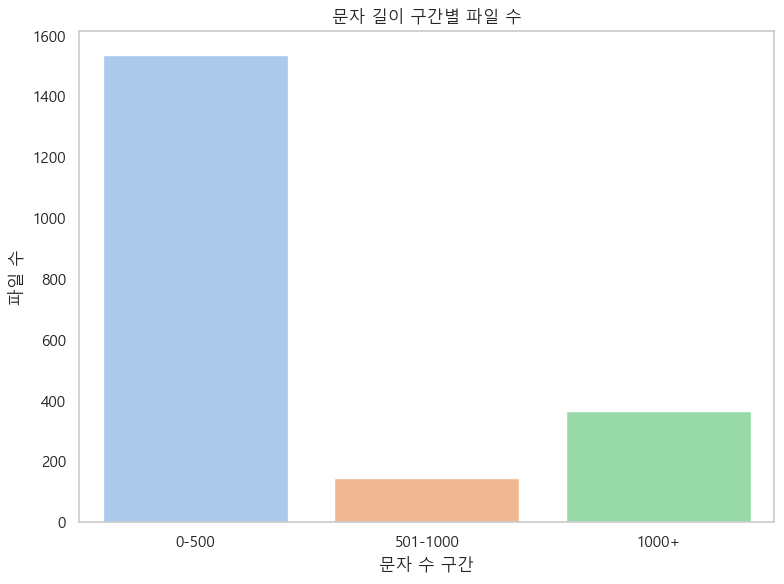

In [ ]:
# --- ✅ 시각화 시작 ---
%matplotlib inline
plt.rcParams["axes.unicode_minus"] = False
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

# 📈 1. 문자 길이 구간별 분포
plt.figure(figsize=(8, 6))
sns.countplot(data=msg_lengths, x="length_group", palette="pastel")
plt.title("문자 길이 구간별 파일 수")
plt.xlabel("문자 수 구간")
plt.ylabel("파일 수")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

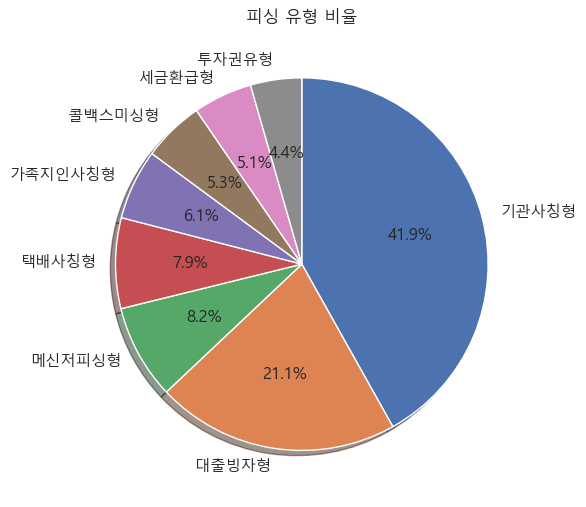

In [27]:
# 🥧 2. 피싱 유형 분포 (원형 차트)
plt.rcParams["axes.unicode_minus"] = False
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

plt.figure(figsize=(6, 6))
msg_lengths["phishing_type"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=90, counterclock=False, shadow=True
)
plt.title("피싱 유형 비율")
plt.ylabel("")
plt.tight_layout()
plt.show()

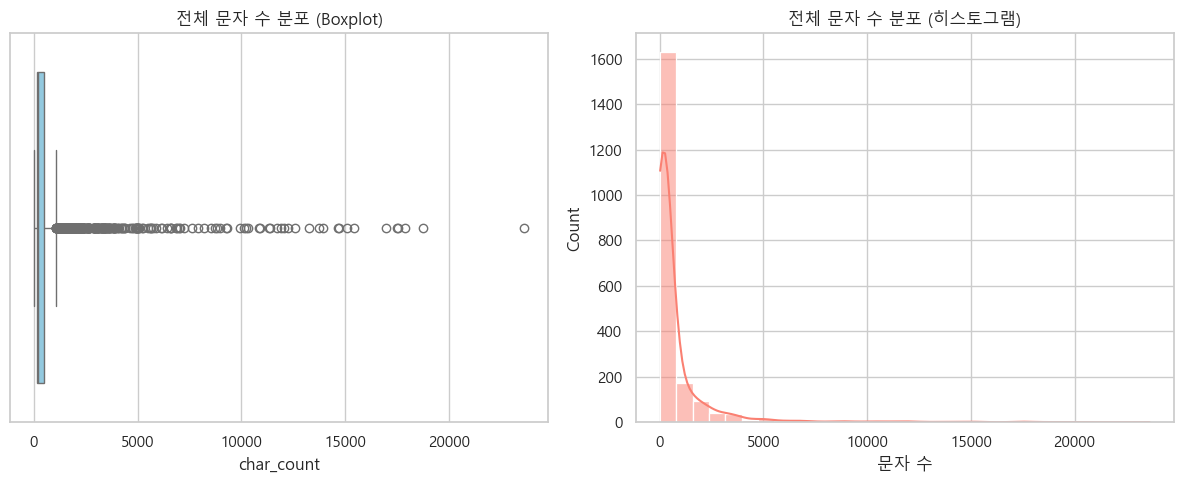

In [28]:
# 📦 3. 전체 문자 수 분포 (Boxplot + Histogram)
plt.rcParams["axes.unicode_minus"] = False
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=msg_lengths["char_count"], color="skyblue")
plt.title("전체 문자 수 분포 (Boxplot)")

plt.subplot(1, 2, 2)
sns.histplot(msg_lengths["char_count"], bins=30, kde=True, color="salmon")
plt.title("전체 문자 수 분포 (히스토그램)")
plt.xlabel("문자 수")

plt.tight_layout()
plt.show()

In [ ]:
from konlpy.tag import Kkma

# 형태소 분석기 객체 생성
kkma = Kkma()


# 형태소 분석 함수 (불용어 제거 없이 주요 품사만 필터링)
def kkma_tokenizer(text):
    try:
        tokens = kkma.pos(text)
        # 명사(NNG, NNP), 동사(VV), 형용사(VA)만 추출
        keywords = [word for word, tag in tokens if tag in ["NNG", "NNP", "VV", "VA"]]
        keywords = [word for word in keywords if word != "OOO"]
        return keywords if keywords else ["없음"]
    except:
        return ["오류"]


# 적용
df["kkma_tokens"] = df["text"].apply(kkma_tokenizer)

# 결과 출력
# print(df)

In [ ]:
from collections import Counter
import pandas as pd

# 모든 키워드를 하나의 리스트로 합치기
all_keywords = sum(df["kkma_tokens"], [])  # 리스트 안 리스트를 평탄화

# 키워드 등장 빈도수 계산
keyword_counter = Counter(all_keywords)

# Counter → DataFrame 변환
keyword_freq_df = pd.DataFrame(
    keyword_counter.items(), columns=["keyword", "frequency"]
)

# 내림차순 정렬
keyword_freq_df = keyword_freq_df.sort_values(
    by="frequency", ascending=False
).reset_index(drop=True)

# 출력
# print(keyword_freq_df)
# 상위 700개 키워드만 추출
top_700_keywords = keyword_freq_df.head(700)

# 결과 확인
print(top_700_keywords)

In [ ]:
# top_700_keywords를 CSV 파일로 저장
top_700_keywords.to_csv("phishing_top_700_keywords.csv", index=False, encoding="utf-8-sig")

# 테스트 데이터를 제외한 피싱데이터셋 분석

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# 📌 Jupyter에서 한글 깨짐 방지 + 스타일 설정
%matplotlib inline
import platform
from matplotlib import font_manager, rc

In [2]:
file_path = '../../dataset/phishing_total.csv'
print(f"'{file_path}' 파일을 읽는 중...")
try:
    df = pd.read_csv(file_path)
    print("파일 읽기 성공.")
except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    exit()
except Exception as e:
    print(f"파일을 읽는 중 오류 발생: {e}")
    exit()

# 'text' 컬럼이 있는지 확인
if 'text' not in df.columns:
    print("오류: CSV 파일에 'text' 컬럼이 없습니다. 컬럼 이름을 확인해주세요.")
    exit()
# 'file_name' 컬럼이 있는지 확인
if 'file_name' not in df.columns:
    print("오류: CSV 파일에 'file_name' 컬럼이 없습니다. 컬럼 이름을 확인해주세요.")
    exit()


'../../dataset/phishing_total.csv' 파일을 읽는 중...
파일 읽기 성공.


In [3]:
# file_name별로 text를 합치고 글자수 계산
# 먼저 text 컬럼을 문자열로 변환하여 NaN 값 처리
df['text'] = df['text'].astype(str)
grouped_df = df.groupby('file_name')['text'].apply(lambda x: ''.join(x)).reset_index()
grouped_df['combined_text_length'] = grouped_df['text'].apply(len)

print("\n--- file_name 별 합쳐진 텍스트 글자수 분포 통계 ---")
print(grouped_df['combined_text_length'].describe())


--- file_name 별 합쳐진 텍스트 글자수 분포 통계 ---
count      766.000000
mean      1837.639687
std       2796.865157
min         20.000000
25%        341.250000
50%        935.000000
75%       2089.000000
max      23615.000000
Name: combined_text_length, dtype: float64


In [4]:
grouped_df.head()

,file_name,text,combined_text_length
0,phishing_1281,장판 문의 좀 드리려고 전화 드렸거든요. 경주교도소 총무과로 해 주시면 돼요. 재소...,199
1,phishing_1282,서울지검 수사관이에요. 다름이 아니고 ㅇㅇ씨 앞으로 명의도용 사건 관련해서 몇 가지...,349
2,phishing_1283,ㅇㅇㅇ씨 같은 경우에는 1차적인 혐의가 없기 때문에 약식으로 녹취 조사로 진행하게 ...,53
3,phishing_1284,서울중앙지검 금융기업범죄 수사탐의 한ㅇㅇ 수사관입니다.,30
4,phishing_1285,특히 이제 고객님이 이쪽을 정리해주신다 하시면 저희쪽에서 바로 진행 가능하시고 이제...,955


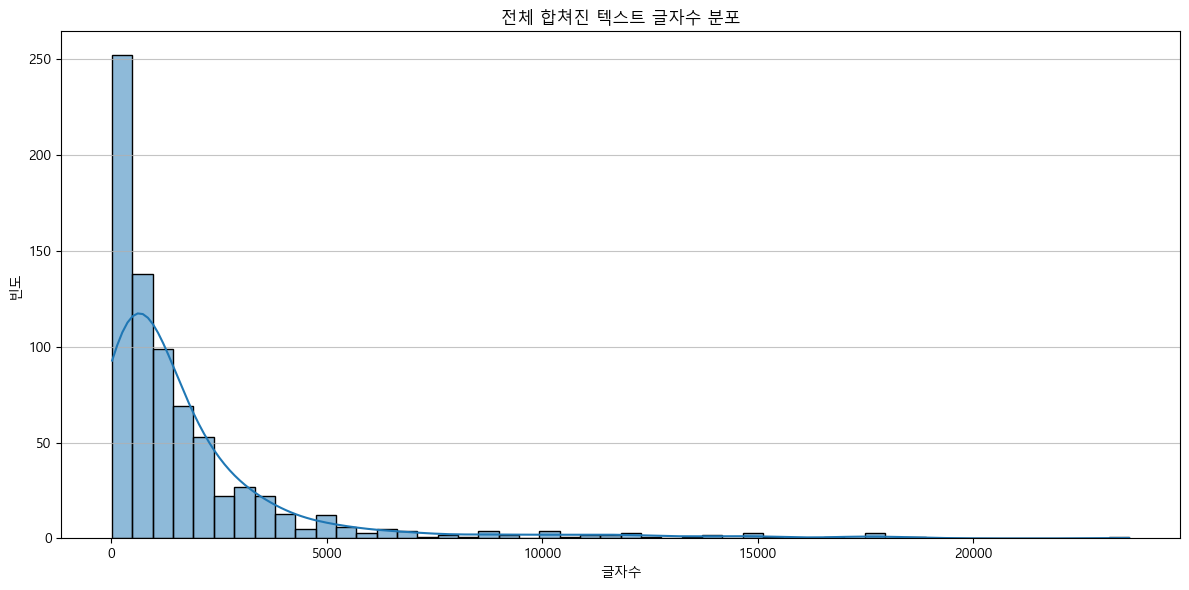

In [5]:
plt.rcParams["axes.unicode_minus"] = False
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

# 전체 합쳐진 텍스트 글자수 분포 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(grouped_df['combined_text_length'], bins=50, kde=True)
plt.title('전체 합쳐진 텍스트 글자수 분포')
plt.xlabel('글자수')
plt.ylabel('빈도')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show() # 그래프 출력

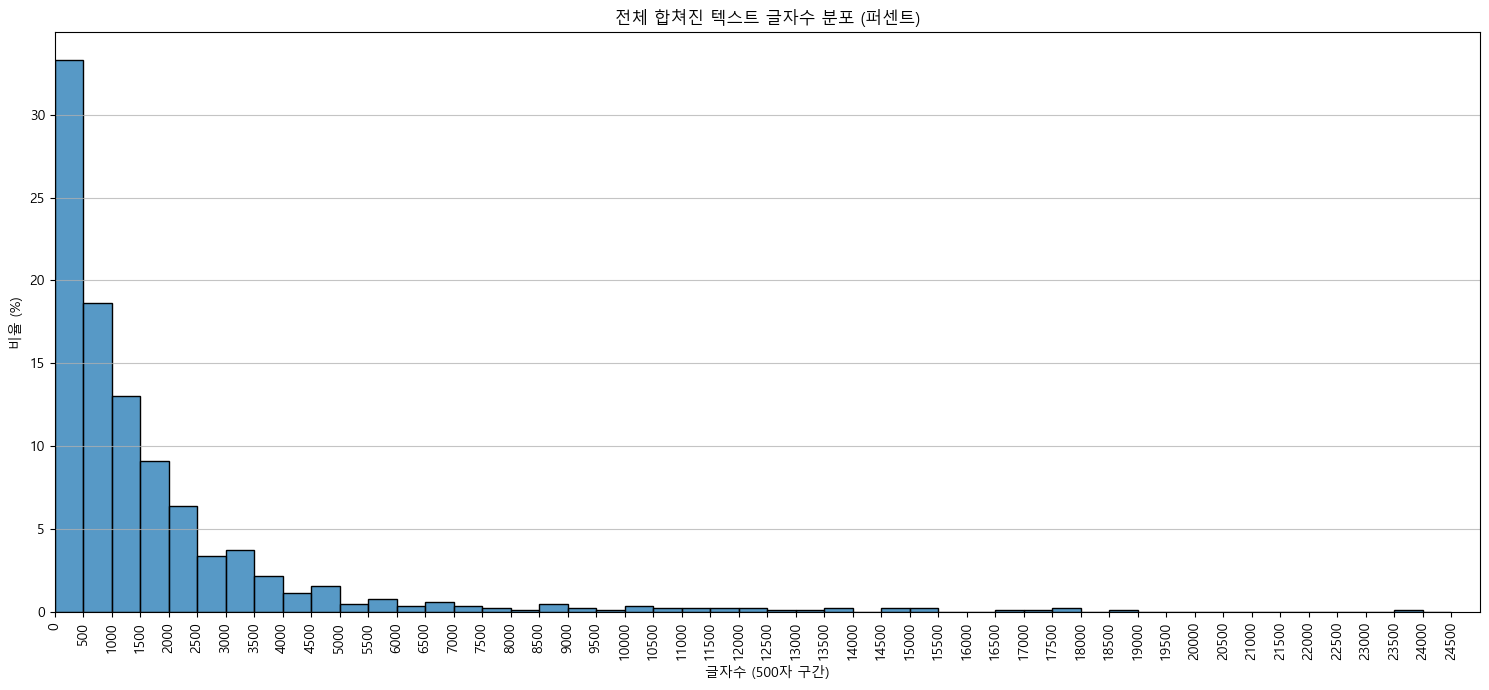

In [8]:
plt.rcParams["axes.unicode_minus"] = False
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)
# 전체 합쳐진 텍스트 글자수 분포 히스토그램 (퍼센트, 500자 구간, 25000자 제한)
plt.figure(figsize=(15, 7))
# 0부터 25000까지 500 간격으로 bin 생성
bins = range(0, 25000, 500)
sns.histplot(grouped_df['combined_text_length'], bins=bins, kde=False, stat='percent')
plt.title('전체 합쳐진 텍스트 글자수 분포 (퍼센트)')
plt.xlabel('글자수 (500자 구간)')
plt.ylabel('비율 (%)')
plt.xticks(bins, rotation=90) # x축 레이블을 bin 경계로 설정하고 회전
plt.xlim(0, 25000) # x축 범위 제한
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show() # 그래프 출력

In [15]:
print(grouped_df[grouped_df["combined_text_length"] <= 500].shape[0])
print(
    grouped_df[
        (grouped_df["combined_text_length"] > 500)
        & (grouped_df["combined_text_length"] <= 1000)
    ].shape[0]
)

255
144


In [17]:
# 구간 정의
bins = [0, 500, 1000, 1500, float("inf")]
labels = ["0~500", "501~1000", "1001~1500", "1501~"]

# 구간에 따라 분류
grouped_df["length_bin"] = pd.cut(
    grouped_df["combined_text_length"], bins=bins, labels=labels, right=True
)

# 구간별 개수 출력
length_counts = grouped_df["length_bin"].value_counts().sort_index()
print(length_counts)

length_bin
0~500        255
501~1000     144
1001~1500     99
1501~        268
Name: count, dtype: int64


In [20]:
# 구간 설정
bins = [0, 500, 1000, 1500, 2000, 5000, float("inf")]
labels = ["0~500", "501~1000", "1001~1500", "1501~2000", "2001~5000", "5000~"]

# 구간 분류
grouped_df["length_bin"] = pd.cut(
    grouped_df["combined_text_length"], bins=bins, labels=labels, right=True
)

# 퍼센트 계산
length_percent = (
    grouped_df["length_bin"].value_counts(normalize=True).sort_index() * 100
)

# 소수점 2자리까지 반올림해서 출력
length_percent = length_percent.round(2)

print(length_percent)

length_bin
0~500        33.29
501~1000     18.80
1001~1500    12.92
1501~2000     9.14
2001~5000    18.54
5000~         7.31
Name: proportion, dtype: float64
